# PPU mix optimization for energy sovereignty

Abstract: Identify the combinations of PPU that balance price minimization, minimization of external dependencies and maximizes renewable energy.  

## Part 1 - Import of data

We import to begin the following descriptions (01.01.2024 to 31.12.2024): 
- Electrical energy spot price 
- Wind repartition 
- Solar incidence
- Exchange rates

### Dependencies

We begin by importing all the necessary libraries

In [4]:
import pandas as pd
import numpy as np
import networkx as nx

import gurobipy as gp
from gurobipy import GRB

import re
import warnings
warnings.filterwarnings("ignore")

# Exterior folders 

from data_visualization import plot_spot_price, analyze_spot_price, analyze_solar_incidence, plot_monthly_solar_apport, analyze_wind_incidence, plot_monthly_wind_apport, analyze_monthly_hourly_load, analyze_exchange_values, visualize_ror_monthly, visualize_storage_monthly


### Data scrapping

We have the following ressources: 
- spot electricity price : https://api.energy-charts.info/?
- solar incidence : https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview
- wind incidence : https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=download
- exchange rate (CHF/EUR) : https://www.exchange-rates.org/exchange-rate-history/chf-eur-2024
- energy consumption in Switzerland (): https://www.entsoe.eu/data/power-stats/
- water RoR (run of river) $\mathrm{m^3}$ per month : https://transparency.entsoe.eu/
- Water storage ($\mathrm{m^3}$) per month : https://www.bfe.admin.ch/bfe/de/home/versorgung/statistik-und-geodaten/
- Water storage total available is $3.5\,\mathrm{km^3}$: https://ethz.ch/content/dam/ethz/special-interest/baug/department/news/dokumente/Hydropower_Synthesis_Report_sm.pdf



### 1 - Spot electricity price 2024

import spot price of electricity derived of the EPEX SPOT price (EUR/MWh). 

In [2]:
# Extract values from spot price JSON and put them in a DataFrame
import json
import pandas as pd
from pathlib import Path

# Load spot price JSON
data_path = Path("data/energy_price_all_2024.json")
with open(data_path, "r") as f:
    spot_data = json.load(f)

# Extract values and create DataFrame
# Assumes spot_data has keys 'unix_seconds' and 'price'
spot_df = pd.DataFrame({
    'time': pd.to_datetime(spot_data['unix_seconds'], unit='s', utc=True),
    'price': spot_data['price']
})
spot_df.set_index('time', inplace=True)

print(spot_df.head())


                           price
time                            
2023-12-31 23:00:00+00:00  25.97
2024-01-01 00:00:00+00:00  21.99
2024-01-01 01:00:00+00:00  14.32
2024-01-01 02:00:00+00:00  11.37
2024-01-01 03:00:00+00:00  11.35


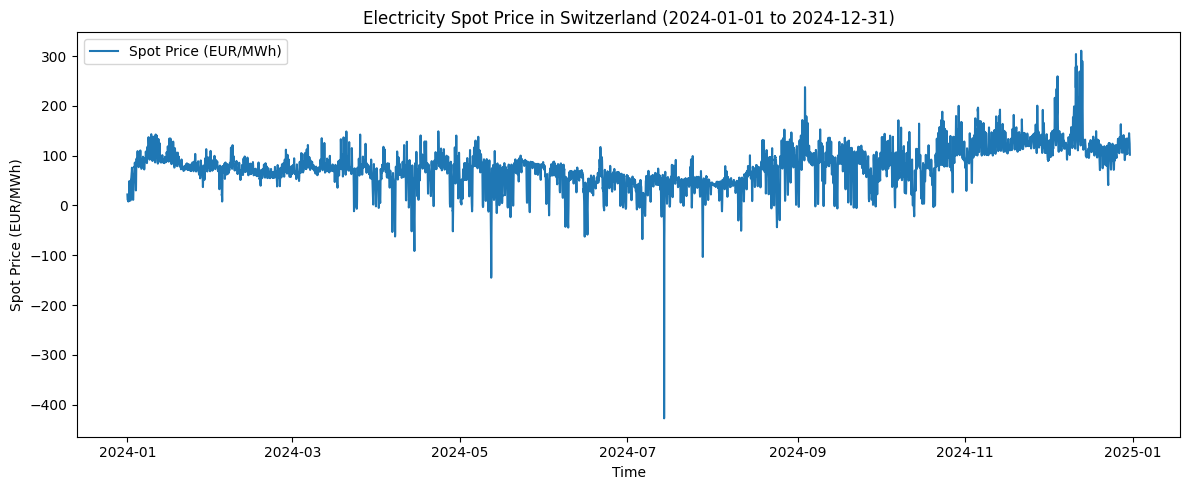

In [3]:
plot_spot_price(
    csv_path = "data/spot_price_hourly.csv",
    start_date = "2024-01-01",
    end_date = "2024-12-31"
    )

Spot Price Statistics (2024-01-01 to 2024-12-31):
  Mean: 75.8649
  Median: 75.7500
  Mode: 78.9400
  Std: 38.9859
  Skewness (3rd moment): -0.1299
  Kurtosis (4th moment): 5.3287


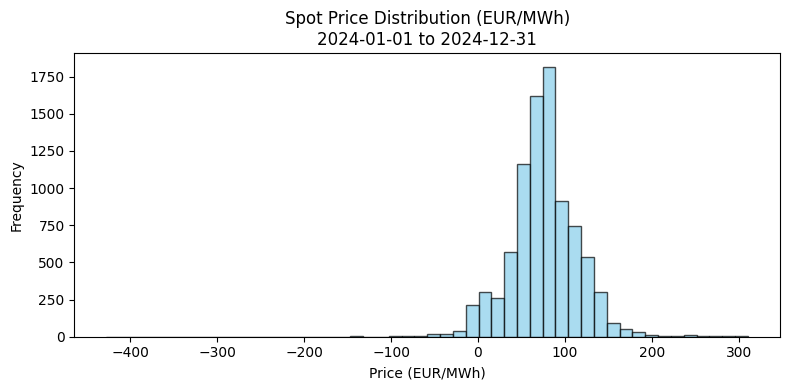

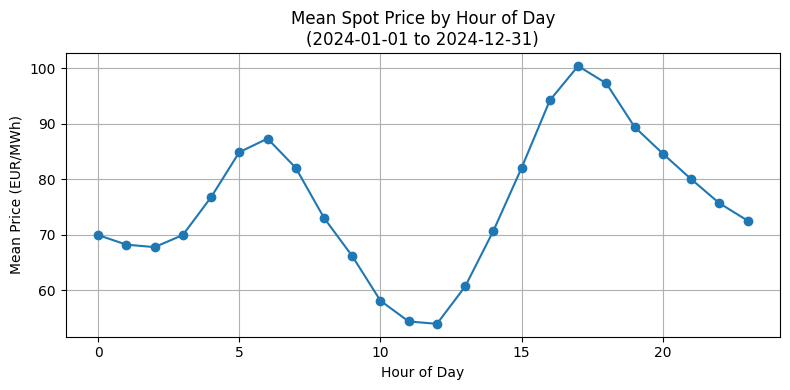

In [4]:
analyze_spot_price( csv_path="data/spot_price_hourly.csv",
    start_date="2024-01-01", 
    end_date="2024-12-31")

### 2 -Solar incidence

import solar incidence data and generate csv. Should only be needed once. Gives the solar incidence (kWh/m^2) per location for 2024:

In [15]:
# FIXED VERSION: Round coordinates to avoid floating-point precision issues
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd

solar_dir = Path("data/solar_incidence")
valid_grib_files = sorted([p for p in solar_dir.rglob("*") if p.is_file() and not p.name.endswith('.idx')])

all_dsets = []
for f in valid_grib_files:
    try:
        ds = xr.open_dataset(
            f,
            engine="cfgrib",
            backend_kwargs={"filter_by_keys": {"shortName": "ssrd"}},
        )
        all_dsets.append(ds)
    except Exception as e:
        print(f"Failed to open {f}: {e}")

if not all_dsets:
    raise RuntimeError("No GRIB datasets could be opened.")

ds_all = xr.combine_by_coords(all_dsets, combine_attrs="override")

var_name = next((v for v in ds_all.data_vars if v.lower() in ("ssrd", "surface_solar_radiation_downwards")), None)
if var_name is None:
    var_name = next((v for v in ds_all.data_vars if "ssrd" in v.lower()), None)
if var_name is None:
    raise KeyError(f"No SSRD-like variable found. Variables: {list(ds_all.data_vars)}")

units_attr = str(ds_all[var_name].attrs.get("units", "")).lower()
if ("j" in units_attr) and ("/m" in units_attr):
    ghi_kwh = ds_all[var_name] / 3600000.0  # J/m^2 per hour -> kWh/m^2 per hour
else:
    ghi_kwh = ds_all[var_name] / 3600000.0

# FIX: Round coordinates to 1 decimal place BEFORE creating DataFrame
# This prevents floating-point representation issues like 5.9 -> 5.8999999999999995
ghi_kwh['latitude'] = np.round(ghi_kwh['latitude'].values, 1)
ghi_kwh['longitude'] = np.round(ghi_kwh['longitude'].values, 1)

df = ghi_kwh.to_dataframe()
df_pivot_fixed = df.pivot_table(index="time", columns=["latitude", "longitude"], values=var_name)
df_pivot_fixed.index.name = "time"

print("FIXED: Hourly solar incidence (kWh/m^2) per location for 2024 with rounded coordinates:")
print(f"Sample coordinates: {df_pivot_fixed.columns[:3].tolist()}")
df_pivot_fixed.head()

FIXED: Hourly solar incidence (kWh/m^2) per location for 2024 with rounded coordinates:
Sample coordinates: [(45.7, 5.8), (45.7, 5.9), (45.7, 6.0)]


latitude        45.7                                                    \
longitude       5.8       5.9       6.0       6.1       6.2       6.3    
time                                                                     
2023-12-31  0.574031  0.591376  0.611221  0.637551  0.658632  0.680419   
2024-01-01  0.742485  0.743898  0.753017  0.774154  0.801859  0.829436   
2024-01-02  0.280265  0.282517  0.289136  0.301330  0.315025  0.329090   
2024-01-03  0.669797  0.665334  0.663887  0.667973  0.667967  0.668626   
2024-01-04  0.796816  0.791967  0.788614  0.786261  0.780852  0.775969   

latitude                                            ...      47.9            \
longitude       6.4       6.5       6.6       6.7   ...      9.8       9.9    
time                                                ...                       
2023-12-31  0.715917  0.797669  0.879526  0.952460  ...  1.042956  1.044736   
2024-01-01  0.854771  0.872536  0.890336  0.907316  ...  0.683688  0.692329   
2024-01-02  0.350258  0.395444  0.440525  0.486945  ...  0.239555  0.248158   
2024-01-03  0.682026  0.738424  0.794783  0.847285  ...  0.605994  0.621983   
2024-01-04  0.781976  0.824666  0.867312  0.907211  ...  0.612017  0.616639   

latitude                                                                \
longitude       10.0      10.1      10.2      10.3      10.4      10.5   
time                                                                     
2023-12-31  1.046423  1.043322  1.040129  1.036899  1.034410  1.033986   
2024-01-01  0.700999  0.711427  0.721884  0.732324  0.741731  0.749711   
2024-01-02  0.256753  0.265146  0.273532  0.282030  0.288811  0.291382   
2024-01-03  0.637965  0.654525  0.671067  0.687474  0.700788  0.710468   
2024-01-04  0.621260  0.626298  0.631348  0.636433  0.642840  0.651075   

latitude                        
longitude       10.6      10.7  
time                            
2023-12-31  1.036098  1.038160  
2024-01-01  0.756495  0.763285  
2024-01-02  0.289758  0.288109  
2024-01-03  0.717992  0.725512  
2024-01-04  0.660695  0.670298  

[5 rows x 1150 columns]

In [16]:
# Export the FIXED version with clean coordinates
output_csv_fixed = "data/solar_incidence_hourly_2024.csv"
df_pivot_fixed.to_csv(output_csv_fixed)
print(f"Saved FIXED solar incidence data to {output_csv_fixed}")

# Verify the fix by checking the CSV header
import csv
with open(output_csv_fixed, 'r') as f:
    reader = csv.reader(f)
    lat_row = next(reader)
    lon_row = next(reader)
    print(f"\nLatitude row (first 10): {lat_row[:10]}")
    print(f"Longitude row (first 10): {lon_row[:10]}")
    print("\n✓ Coordinates should now show clean values like 5.9 instead of 5.8999999999999995")

Saved FIXED solar incidence data to data/solar_incidence_hourly_2024.csv

Latitude row (first 10): ['latitude', '45.7', '45.7', '45.7', '45.7', '45.7', '45.7', '45.7', '45.7', '45.7']
Longitude row (first 10): ['longitude', '5.8', '5.9', '6.0', '6.1', '6.2', '6.3', '6.4', '6.5', '6.6']

✓ Coordinates should now show clean values like 5.9 instead of 5.8999999999999995


In [7]:
# Fix matplotlib import issue by resetting matplotlib state
import importlib
import sys

# Remove all matplotlib-related modules from cache
modules_to_remove = [k for k in sys.modules.keys() if k.startswith('matplotlib') or k == 'data_visualization']
for mod in modules_to_remove:
    del sys.modules[mod]
    print(f"Removed {mod} from cache")

# Fresh import of matplotlib
try:
    import matplotlib
    import matplotlib.pyplot as plt
    print(f"\n✓ Matplotlib version: {matplotlib.__version__}")
    print(f"✓ Matplotlib location: {matplotlib.__file__}")
    print(f"✓ Backend: {matplotlib.get_backend()}")
except Exception as e:
    print(f"\n✗ Matplotlib import error: {e}")

# Re-import data_visualization module
try:
    from data_visualization import analyze_solar_incidence
    print(f"\n✓ Successfully re-imported data_visualization module")
except Exception as e:
    print(f"\n✗ Failed to import data_visualization: {e}")

Removed matplotlib._api.deprecation from cache
Removed matplotlib._api from cache
Removed matplotlib._version from cache
Removed matplotlib._c_internal_utils from cache
Removed matplotlib.cbook from cache
Removed matplotlib._docstring from cache
Removed matplotlib.backends.registry from cache
Removed matplotlib.backends from cache
Removed matplotlib._cm from cache
Removed matplotlib._path from cache
Removed matplotlib.bezier from cache
Removed matplotlib.path from cache
Removed matplotlib.transforms from cache
Removed matplotlib.ticker from cache
Removed matplotlib.scale from cache
Removed matplotlib._image from cache
Removed matplotlib._color_data from cache
Removed matplotlib.colors from cache
Removed matplotlib._fontconfig_pattern from cache
Removed matplotlib._enums from cache
Removed matplotlib.rcsetup from cache
Removed matplotlib.ft2font from cache
Removed matplotlib.artist from cache
Removed matplotlib.colorizer from cache
Removed matplotlib._cm_listed from cache
Removed matplo

Solar Incidence Statistics (2024-01-01 to 2024-12-31):
  Mean: 1.8981 kWh/m^2
  Median: 1.6443 kWh/m^2
  Mode: 0.9437 kWh/m^2
  Std: 1.0916 kWh/m^2
  Skewness: 0.3574
  Kurtosis: -1.1005


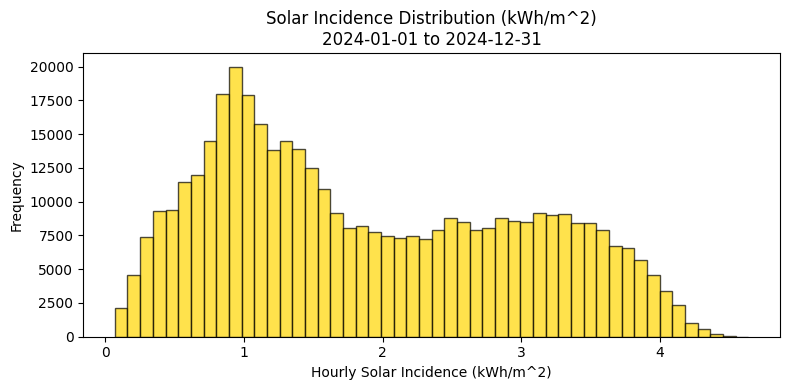

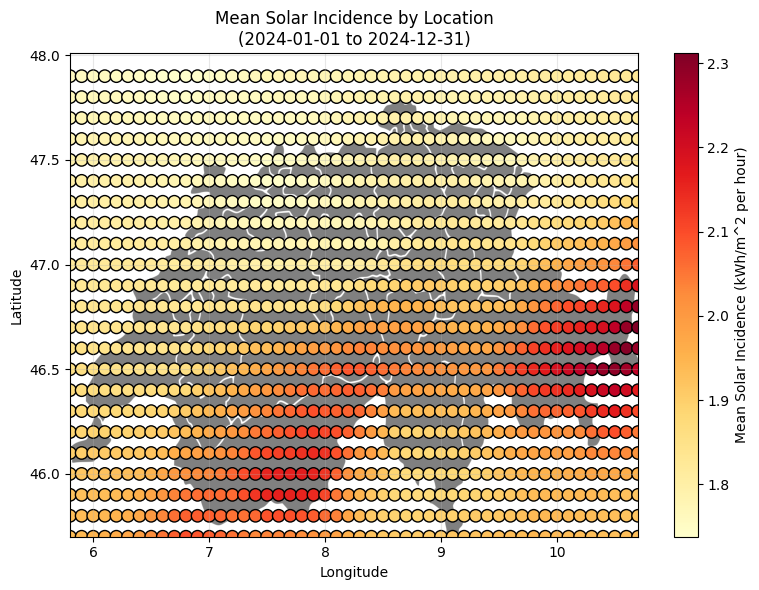

In [17]:
analyze_solar_incidence(
    "data/solar_incidence_hourly_2024.csv",
    start_date="2024-01-01",
    end_date="2024-12-31",
    background_img_path="data/Switzerland.png"
)

#### Ranking ideal positions

Ranking ideal positions to install PV

In [18]:
import os
import pandas as pd
import numpy as np
import csv

# Create ranking_incidence folder if not exists
os.makedirs("data/ranking_incidence", exist_ok=True)

# Load solar incidence CSV
csv_path = "data/solar_incidence_hourly_2024.csv"

# Read the header rows to get lat/lon
with open(csv_path, 'r') as f:
    reader = csv.reader(f)
    lat_row = next(reader)
    lon_row = next(reader)
    # Skip time_row
    next(reader)

# Read the data, skipping first 3 rows
df = pd.read_csv(csv_path, skiprows=3)
df.rename(columns={df.columns[0]: "time"}, inplace=True)
df["time"] = pd.to_datetime(df["time"])

# Data columns (each is a location)
data_cols = [col for col in df.columns if col != "time"]

# Compute mean solar incidence per location
mean_by_loc = df[data_cols].mean()

# Extract lat/lon for each location (skip first element if it's empty)
lats = [float(x) for x in lat_row[1:]]
lons = [float(x) for x in lon_row[1:]]

# Create DataFrame
ranking_df = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'mean_solar_incidence_kwh_m2_per_hour': mean_by_loc.values
})

# Sort by mean descending (highest incidence first)
ranking_df = ranking_df.sort_values('mean_solar_incidence_kwh_m2_per_hour', ascending=False).reset_index(drop=True)

# Add rank column
ranking_df['rank'] = ranking_df.index + 1

# Save to CSV
output_csv = "data/ranking_incidence/solar_incidence_ranking.csv"
ranking_df.to_csv(output_csv, index=False)

print(f"Saved solar incidence ranking to {output_csv}")
print("Top 10 locations:")
print(ranking_df.head(10))

Saved solar incidence ranking to data/ranking_incidence/solar_incidence_ranking.csv
Top 10 locations:
   latitude  longitude  mean_solar_incidence_kwh_m2_per_hour  rank
0      46.7       10.7                              2.311835     1
1      46.6       10.6                              2.304564     2
2      46.5       10.5                              2.292172     3
3      46.5       10.4                              2.286543     4
4      46.8       10.7                              2.285850     5
5      46.7       10.6                              2.284380     6
6      46.6       10.5                              2.283687     7
7      46.6       10.7                              2.282733     8
8      46.5       10.6                              2.272949     9
9      46.5       10.3                              2.260952    10


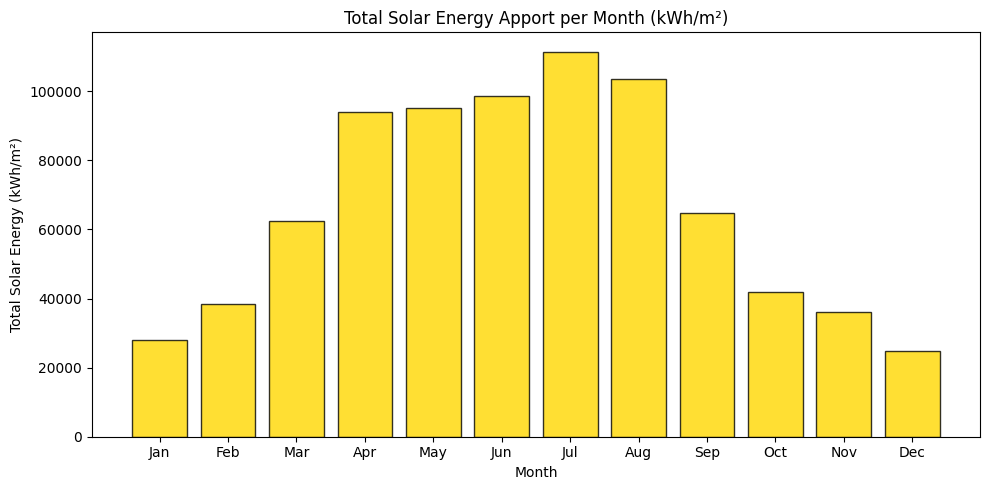

In [19]:
plot_monthly_solar_apport(
    "data/solar_incidence_hourly_2024.csv", 
    start_date="2024-01-01", 
    end_date="2024-12-31"
    )

### 3 - Wind incidence 

Wind incidence is given by 10m u-component of wind, 10m v-component of wind in (m/s).

In [1]:
# List and open one file from data/wind_incidence to inspect its contents
from pathlib import Path
import xarray as xr

wind_dir = Path("data/wind_incidence")
# List all files (excluding .idx)
wind_files = sorted([p for p in wind_dir.rglob("*") if p.is_file() and not p.name.endswith('.idx')])
print(f"Found {len(wind_files)} files. First file: {wind_files[0] if wind_files else 'None'}")

# Open the first file and print its structure
if wind_files:
    ds = xr.open_dataset(wind_files[0], engine="cfgrib")
    print(ds)
    print("Variables:", list(ds.data_vars))
    print("Attributes:", ds.attrs)
else:
    print("No wind incidence files found.")

Found 12 files. First file: data/wind_incidence/apr2024_wind.grib
<xarray.Dataset> Size: 7MB
Dimensions:     (time: 31, step: 24, latitude: 23, longitude: 50)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 248B 2024-03-31 2024-04-01 ... 2024-04-30
  * step        (step) timedelta64[ns] 192B 01:00:00 ... 1 days 00:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 184B 47.9 47.8 47.7 47.6 ... 45.9 45.8 45.7
  * longitude   (longitude) float64 400B 5.8 5.9 6.0 6.1 ... 10.4 10.5 10.6 10.7
    valid_time  (time, step) datetime64[ns] 6kB ...
Data variables:
    u10         (time, step, latitude, longitude) float32 3MB ...
    v10         (time, step, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Eu

/Users/gs/.pyenv/versions/3.11.0/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [12]:
# Concatenate all wind incidence files into a single DataFrame (hourly wind speed) for the full year
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd

wind_dir = Path("data/wind_incidence")
wind_files = sorted([p for p in wind_dir.rglob("*") if p.is_file() and not p.name.endswith('.idx')])

print("Wind files found:")
for wf in wind_files:
    print("  ", wf)

all_dfs = []
opened_files = []
for f in wind_files:
    try:
        ds = xr.open_dataset(f, engine="cfgrib")
        wind_speed = np.sqrt(ds["u10"]**2 + ds["v10"]**2)
        # If 'valid_time' exists, use it as the time coordinate
        if "valid_time" in ds:
            wind_speed = wind_speed.assign_coords(time=ds["valid_time"])
        df = wind_speed.to_dataframe(name="wind_speed").reset_index()
        all_dfs.append(df)
        opened_files.append(str(f))
    except Exception as e:
        print(f"Failed to open {f}: {e}")

print("Successfully opened files:")
for of in opened_files:
    print("  ", of)

if not all_dfs:
    raise RuntimeError("No valid wind incidence dataframes could be loaded.")

# Concatenate all months
wind_data_df = pd.concat(all_dfs, ignore_index=True)
print(wind_data_df.head())
print("Shape:", wind_data_df.shape)

# Use 'valid_time' as the datetime index for pivoting
wind_data_df = wind_data_df.rename(columns={"valid_time": "datetime"})
wind_data_df = wind_data_df.dropna(subset=["wind_speed", "datetime"])

# FIX: Round coordinates to 1 decimal place to ensure clean headers and faster IO
wind_data_df["latitude"] = wind_data_df["latitude"].round(1)
wind_data_df["longitude"] = wind_data_df["longitude"].round(1)

# Pivot to wide format (hourly timeseries per (lat, lon))
wind_pivot = wind_data_df.pivot_table(index="datetime", columns=["latitude", "longitude"], values="wind_speed")
wind_pivot.index.name = "datetime"
print(wind_pivot.head())

# Save to CSV
wind_pivot.to_csv("data/wind_incidence_hourly_2024.csv")
print("Saved all wind incidence data to data/wind_incidence_hourly_2024.csv")

Wind files found:
   data/wind_incidence/apr2024_wind.grib
   data/wind_incidence/aug2024_wind.grib
   data/wind_incidence/dec2024_wind.grib
   data/wind_incidence/feb2024_wind.grib
   data/wind_incidence/jan2024_wind.grib
   data/wind_incidence/july2024_wind.grib
   data/wind_incidence/jun2024_wind.grib
   data/wind_incidence/mar2024_wind.grib
   data/wind_incidence/may2024_wind.grib
   data/wind_incidence/nov2024_wind.grib
   data/wind_incidence/oct2024_wind.grib
   data/wind_incidence/sept2024_wind.grib
Successfully opened files:
   data/wind_incidence/apr2024_wind.grib
   data/wind_incidence/aug2024_wind.grib
   data/wind_incidence/dec2024_wind.grib
   data/wind_incidence/feb2024_wind.grib
   data/wind_incidence/jan2024_wind.grib
   data/wind_incidence/july2024_wind.grib
   data/wind_incidence/jun2024_wind.grib
   data/wind_incidence/mar2024_wind.grib
   data/wind_incidence/may2024_wind.grib
   data/wind_incidence/nov2024_wind.grib
   data/wind_incidence/oct2024_wind.grib
   data/w

Wind Speed Statistics (2024-01-01 to 2024-12-31):
  Mean: 1.3393 m/s
  Median: 1.1305 m/s
  Mode: 1.0440 m/s
  Std: 0.9368 m/s
  Skewness: 1.9479
  Kurtosis: 5.6951


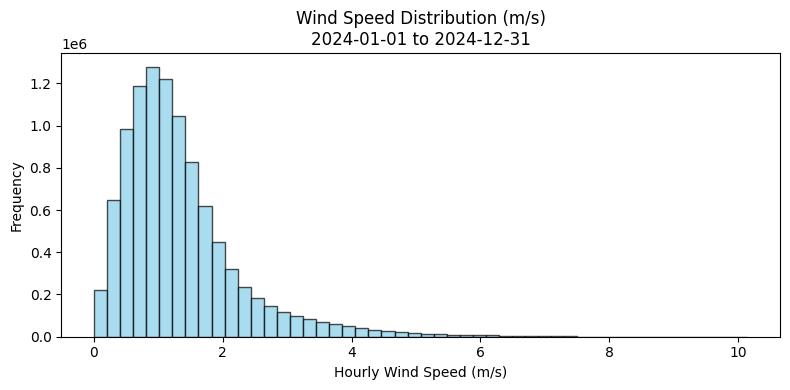

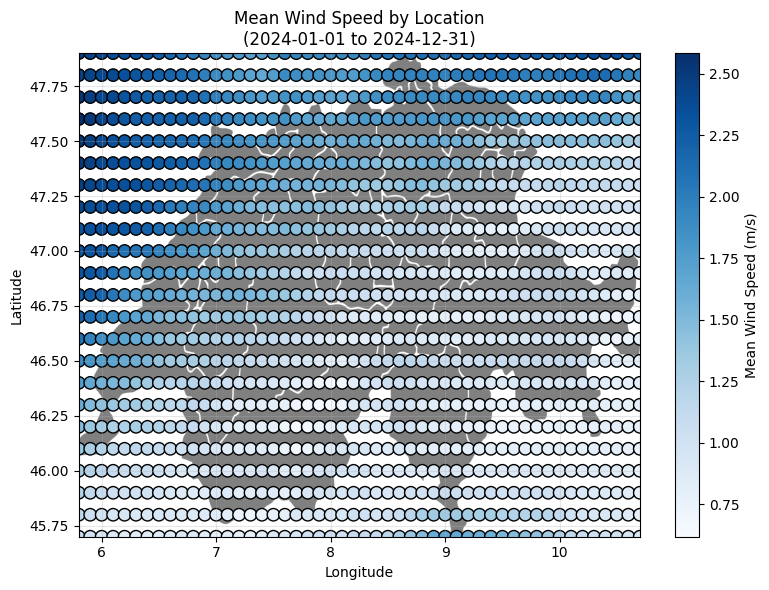

In [6]:
analyze_wind_incidence(
    "data/wind_incidence_hourly_2024.csv",
    start_date="2024-01-01",
    end_date="2024-12-31",
    background_img_path="data/Switzerland.png"
)

#### Ranking ideal positions

Ranking ideal positions to install wind turbines

In [11]:
import os
import pandas as pd
import numpy as np

# Create ranking_incidence folder if not exists (already created by solar)
os.makedirs("data/ranking_incidence", exist_ok=True)

# Load wind incidence CSV
csv_path = "data/wind_incidence_hourly_2024.csv"

# Read the data with MultiIndex columns
df = pd.read_csv(csv_path, index_col=0, header=[0,1], parse_dates=True)

# Data columns (each is a location tuple (lat, lon))
data_cols = df.columns

# Compute mean wind speed per location
mean_by_loc = df[data_cols].mean()

# Extract lat/lon for each location
# Convert to float64 and round to 1 decimal place to avoid precision issues
lats = [round(float(col[0]), 1) for col in data_cols]
lons = [round(float(col[1]), 1) for col in data_cols]

# Create DataFrame with explicit float64 dtype
ranking_df = pd.DataFrame({
    'latitude': pd.Series(lats, dtype='float64'),
    'longitude': pd.Series(lons, dtype='float64'),
    'mean_wind_speed_m_per_s': mean_by_loc.values
})

# Sort by mean descending (highest wind speed first)
ranking_df = ranking_df.sort_values('mean_wind_speed_m_per_s', ascending=False).reset_index(drop=True)

# Add rank column
ranking_df['rank'] = ranking_df.index + 1

# Save to CSV
output_csv = "data/ranking_incidence/wind_incidence_ranking.csv"
ranking_df.to_csv(output_csv, index=False)

print(f"Saved wind incidence ranking to {output_csv}")
print("Top 10 locations:")
print(ranking_df.head(10))

Saved wind incidence ranking to data/ranking_incidence/wind_incidence_ranking.csv
Top 10 locations:
   latitude  longitude  mean_wind_speed_m_per_s  rank
0      47.6        5.8                 2.580371     1
1      47.5        5.8                 2.534964     2
2      47.7        5.8                 2.533673     3
3      47.4        5.8                 2.508964     4
4      47.6        5.9                 2.504037     5
5      47.7        5.9                 2.466343     6
6      47.9        5.8                 2.465996     7
7      47.8        5.8                 2.465354     8
8      47.3        5.8                 2.463216     9
9      47.5        5.9                 2.461883    10


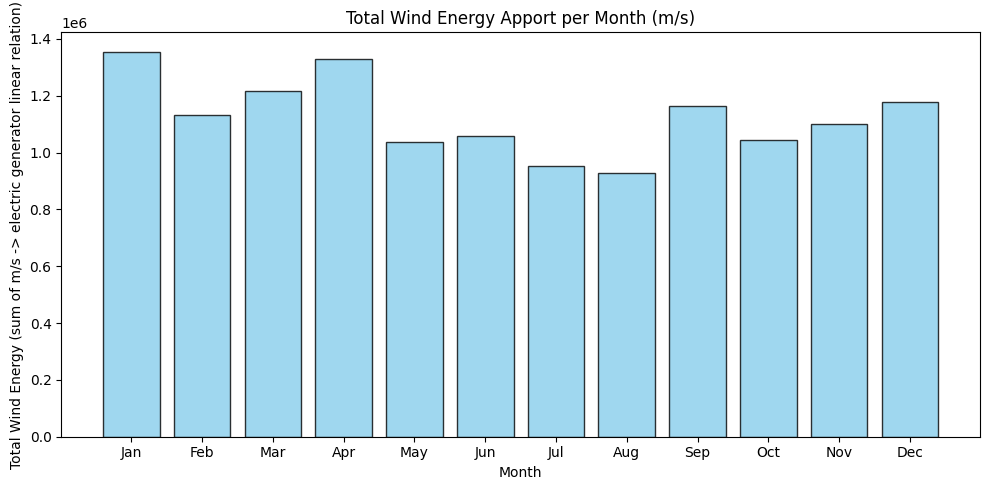

In [8]:
plot_monthly_wind_apport(
    "data/wind_incidence_hourly_2024.csv", 
    start_date="2024-01-01", 
    end_date="2024-12-31"
    )

### Numerical stability

Going over solar and wind incidence and achieving numerical stability

### 4 - Exchange values

Exchange values to transform Eur/MWh in CHF/MWh.

In [ ]:
# Inspect the head of the CHF to EUR exchange rate CSV
exchange_csv = "data/chf_to_eur_2024.csv"
df_exchange = pd.read_csv(exchange_csv)
df_exchange.head()

In [ ]:
analyze_exchange_values("data/chf_to_eur_2024.csv")

### 5 - Hourly consumption rate

Hourly consumption rate of energy in Switzerland. Csv was ready for usage. 

In [ ]:
analyze_monthly_hourly_load(
    "data/monthly_hourly_load_values_2024.csv", 
    start_date="2024-01-01", 
    end_date="2024-12-31"
    )

### Water Apport

The hydraulic power is the most important in Switzerland representing nearly 60% of the generated power. We must divide into 3 subcategories which are: 
- RoR (run of river): water that flows in a river and is not controlable, we can merely choose to turbinate. Famous example is the Rhône.  
- Storage (using a dam): water can be stored in the sense that we can choose the tiiming of it's conversion from potential energy to electric energy. Total possible volume would be $3.5\,\mathrm{km^3}$
- Turbinable (pumping water upwards) : water can be pumped up and stored which allows to discharge the grid and charge the water with potential energy.

Each of these sources present different challenges and opportunities. We will treat 2 datasets (RoR and Storage) to provide an idea of the magnitude of such consumptions. Finally we will treat the Turbinable as merely a flexible option. 


(source: 
- https://www.bfe.admin.ch/bfe/en/home/supply/renewable-energy/hydropower.html/#:~:text=Thanks%20to%20its%20topography%20and,in%20pumped%20storage%20power%20plants.)

#### 1 - RoR study 

RoR is considered all energy that is gained from runing water without human control. 

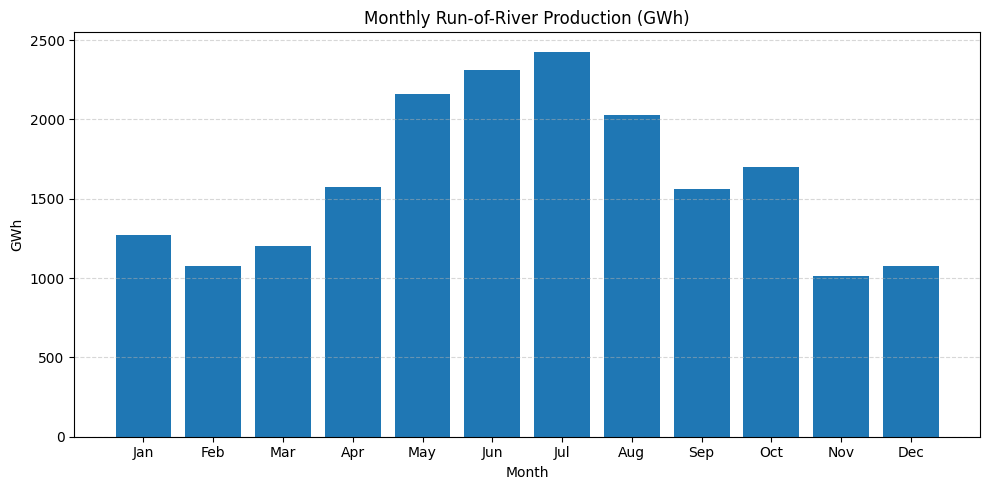

In [ ]:
visualize_ror_monthly(
    "data/water_monthly_ror_2024.csv",
    start_date="2024-01-01",
    end_date="2024-12-31"
)


#### Disaggregate monthly RoR data to 15-minute intervals

Convert monthly total energy (GWh) to 15-minute power values (MW) using cubic spline interpolation for smooth transitions between months.

In [22]:
# Disaggregate monthly RoR data to 15-minute intervals
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Load monthly RoR data
monthly_ror = pd.read_csv("data/water_monthly_ror_2024.csv")
monthly_ror['Month'] = pd.to_datetime(monthly_ror['Month'])
monthly_ror = monthly_ror.set_index('Month')

print("Monthly RoR data (GWh):")
print(monthly_ror)
print(f"\nTotal annual RoR: {monthly_ror['RoR_GWh'].sum():.2f} GWh")

# Step 1: Convert monthly energy (GWh) to average power (MW) for each month
# Power (MW) = Energy (GWh) / Hours in month * 1000
monthly_ror['days_in_month'] = monthly_ror.index.days_in_month
monthly_ror['hours_in_month'] = monthly_ror['days_in_month'] * 24
monthly_ror['avg_power_MW'] = (monthly_ror['RoR_GWh'] / monthly_ror['hours_in_month']) * 1000

print("\nMonthly average power (MW):")
print(monthly_ror[['RoR_GWh', 'avg_power_MW']])

# Step 2: Create interpolation points at middle of each month
# For cubic spline, we need x (day of year) and y (power in MW)
month_midpoints = []
power_values = []

for idx, row in monthly_ror.iterrows():
    # Calculate middle day of the month
    days_in_month = idx.days_in_month
    mid_day = idx + pd.Timedelta(days=days_in_month/2)
    month_midpoints.append(mid_day)
    power_values.append(row['avg_power_MW'])

# Convert to numeric for interpolation (days since start of year)
start_of_year = pd.Timestamp('2024-01-01')
x_days = np.array([(d - start_of_year).total_seconds() / 86400 for d in month_midpoints])
y_power = np.array(power_values)

print(f"\nInterpolation points: {len(x_days)} months")
print(f"Power range: {y_power.min():.2f} - {y_power.max():.2f} MW")

# Step 3: Create 15-minute timestamp range for full year aligned with spot prices
timestamps_15min = pd.date_range(
    start='2024-01-01 00:00:00',
    end='2024-12-31 23:45:00',
    freq='15min'
)

print(f"\n15-minute intervals: {len(timestamps_15min)} timesteps")
print(f"Time range: {timestamps_15min[0]} to {timestamps_15min[-1]}")

Monthly RoR data (GWh):
            RoR_GWh
Month              
2024-01-01     1270
2024-02-01     1077
2024-03-01     1204
2024-04-01     1574
2024-05-01     2158
2024-06-01     2310
2024-07-01     2428
2024-08-01     2026
2024-09-01     1564
2024-10-01     1703
2024-11-01     1015
2024-12-01     1074

Total annual RoR: 19403.00 GWh

Monthly average power (MW):
            RoR_GWh  avg_power_MW
Month                            
2024-01-01     1270   1706.989247
2024-02-01     1077   1547.413793
2024-03-01     1204   1618.279570
2024-04-01     1574   2186.111111
2024-05-01     2158   2900.537634
2024-06-01     2310   3208.333333
2024-07-01     2428   3263.440860
2024-08-01     2026   2723.118280
2024-09-01     1564   2172.222222
2024-10-01     1703   2288.978495
2024-11-01     1015   1409.722222
2024-12-01     1074   1443.548387

Interpolation points: 12 months
Power range: 1409.72 - 3263.44 MW

15-minute intervals: 35136 timesteps
Time range: 2024-01-01 00:00:00 to 2024-12-31 23:45:00

In [23]:
# Step 4: Perform cubic spline interpolation
# Add boundary conditions: wrap around to create smooth year-end transition
# Prepend previous December and append next January for continuity
x_extended = np.concatenate([
    [x_days[0] - 365],  # Previous year December
    x_days,
    [x_days[-1] + 365]  # Next year January
])
y_extended = np.concatenate([
    [y_power[-1]],  # Use Dec 2024 value for Dec 2023
    y_power,
    [y_power[0]]   # Use Jan 2024 value for Jan 2025
])

# Create cubic spline interpolator
cs = CubicSpline(x_extended, y_extended, bc_type='natural')

# Interpolate to 15-minute resolution
x_15min = np.array([(t - start_of_year).total_seconds() / 86400 for t in timestamps_15min])
power_15min_MW = cs(x_15min)

# Ensure non-negative values (in case spline creates small negatives)
power_15min_MW = np.maximum(power_15min_MW, 0)

print(f"Interpolated power range: {power_15min_MW.min():.2f} - {power_15min_MW.max():.2f} MW")
print(f"Mean power: {power_15min_MW.mean():.2f} MW")

# Step 5: Create DataFrame
df_ror_15min = pd.DataFrame({
    'timestamp': timestamps_15min,
    'RoR_MW': power_15min_MW
})

print("\nFirst 10 rows:")
print(df_ror_15min.head(10))
print("\nLast 10 rows:")
print(df_ror_15min.tail(10))

Interpolated power range: 1300.17 - 3295.70 MW
Mean power: 2209.56 MW

First 10 rows:
            timestamp       RoR_MW
0 2024-01-01 00:00:00  1792.021269
1 2024-01-01 00:15:00  1791.968392
2 2024-01-01 00:30:00  1791.915508
3 2024-01-01 00:45:00  1791.862620
4 2024-01-01 01:00:00  1791.809725
5 2024-01-01 01:15:00  1791.756825
6 2024-01-01 01:30:00  1791.703919
7 2024-01-01 01:45:00  1791.651008
8 2024-01-01 02:00:00  1791.598091
9 2024-01-01 02:15:00  1791.545168

Last 10 rows:
                timestamp       RoR_MW
35126 2024-12-31 21:30:00  1604.790065
35127 2024-12-31 21:45:00  1604.892493
35128 2024-12-31 22:00:00  1604.994913
35129 2024-12-31 22:15:00  1605.097324
35130 2024-12-31 22:30:00  1605.199725
35131 2024-12-31 22:45:00  1605.302118
35132 2024-12-31 23:00:00  1605.404502
35133 2024-12-31 23:15:00  1605.506878
35134 2024-12-31 23:30:00  1605.609244
35135 2024-12-31 23:45:00  1605.711601


In [ ]:
# Step 6: Validation - Check energy conservation
# Sum of 15-min power values should approximately equal annual energy
# Energy (GWh) = Power (MW) * Time (hours) / 1000
energy_per_15min_GWh = power_15min_MW * (15/60) / 1000  # 15 minutes = 0.25 hours
total_energy_15min = energy_per_15min_GWh.sum()
original_annual_energy = monthly_ror['RoR_GWh'].sum()

print("=" * 60)
print("ENERGY CONSERVATION CHECK")
print("=" * 60)
print(f"Original monthly total:     {original_annual_energy:.2f} GWh")
print(f"Interpolated 15-min total:  {total_energy_15min:.2f} GWh")
print(f"Difference:                 {abs(total_energy_15min - original_annual_energy):.2f} GWh")
print(f"Relative error:             {abs(total_energy_15min - original_annual_energy) / original_annual_energy * 100:.4f}%")
print("=" * 60)

# Small difference is expected due to interpolation smoothing

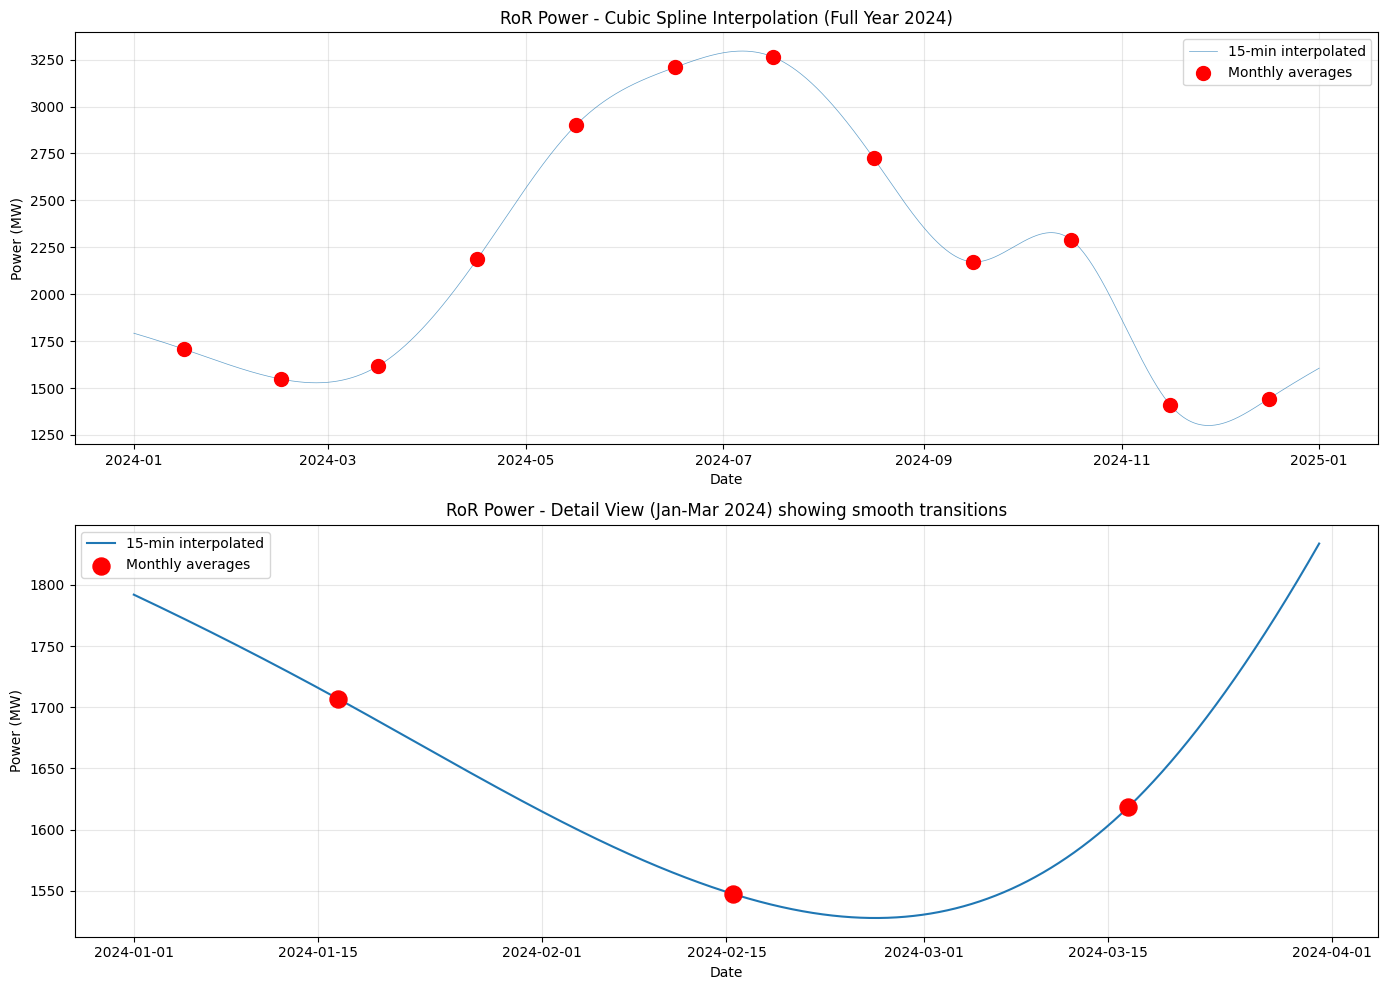


✓ Visualization shows smooth cubic spline interpolation between monthly values


In [24]:
# Step 7: Visualize the interpolation
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full year overview
ax1.plot(df_ror_15min['timestamp'], df_ror_15min['RoR_MW'], 
         linewidth=0.5, alpha=0.7, label='15-min interpolated')
ax1.scatter(month_midpoints, power_values, 
           color='red', s=100, zorder=5, label='Monthly averages', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Power (MW)')
ax1.set_title('RoR Power - Cubic Spline Interpolation (Full Year 2024)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Zoom on January-March to show smooth transitions
jan_mar_mask = (df_ror_15min['timestamp'] >= '2024-01-01') & (df_ror_15min['timestamp'] <= '2024-03-31')
ax2.plot(df_ror_15min.loc[jan_mar_mask, 'timestamp'], 
         df_ror_15min.loc[jan_mar_mask, 'RoR_MW'],
         linewidth=1.5, label='15-min interpolated')
jan_mar_months = [m for m in month_midpoints if m <= pd.Timestamp('2024-03-31')]
jan_mar_power = power_values[:len(jan_mar_months)]
ax2.scatter(jan_mar_months, jan_mar_power,
           color='red', s=150, zorder=5, label='Monthly averages', marker='o')
ax2.set_xlabel('Date')
ax2.set_ylabel('Power (MW)')
ax2.set_title('RoR Power - Detail View (Jan-Mar 2024) showing smooth transitions')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n✓ Visualization shows smooth cubic spline interpolation between monthly values")

In [26]:
# Step 8: Export to CSV
output_csv = "data/water_quarterly_ror_2024.csv"
df_ror_15min.to_csv(output_csv, index=False)

print(f"✓ Saved 15-minute RoR data to {output_csv}")
print(f"\nFile statistics:")
print(f"  - Rows: {len(df_ror_15min):,}")
print(f"  - Columns: {list(df_ror_15min.columns)}")
print(f"  - Time range: {df_ror_15min['timestamp'].min()} to {df_ror_15min['timestamp'].max()}")
print(f"  - Power range: {df_ror_15min['RoR_MW'].min():.2f} - {df_ror_15min['RoR_MW'].max():.2f} MW")

# Preview the file
print("\n" + "="*60)
print("PREVIEW OF water_quarterly_ror_2024.csv")
print("="*60)
print(df_ror_15min.head(20).to_string(index=False))

✓ Saved 15-minute RoR data to data/water_quarterly_ror_2024.csv

File statistics:
  - Rows: 35,136
  - Columns: ['timestamp', 'RoR_MW']
  - Time range: 2024-01-01 00:00:00 to 2024-12-31 23:45:00
  - Power range: 1300.17 - 3295.70 MW

PREVIEW OF water_quarterly_ror_2024.csv
          timestamp      RoR_MW
2024-01-01 00:00:00 1792.021269
2024-01-01 00:15:00 1791.968392
2024-01-01 00:30:00 1791.915508
2024-01-01 00:45:00 1791.862620
2024-01-01 01:00:00 1791.809725
2024-01-01 01:15:00 1791.756825
2024-01-01 01:30:00 1791.703919
2024-01-01 01:45:00 1791.651008
2024-01-01 02:00:00 1791.598091
2024-01-01 02:15:00 1791.545168
2024-01-01 02:30:00 1791.492240
2024-01-01 02:45:00 1791.439306
2024-01-01 03:00:00 1791.386366
2024-01-01 03:15:00 1791.333421
2024-01-01 03:30:00 1791.280470
2024-01-01 03:45:00 1791.227513
2024-01-01 04:00:00 1791.174551
2024-01-01 04:15:00 1791.121583
2024-01-01 04:30:00 1791.068609
2024-01-01 04:45:00 1791.015630


#### Summary: Monthly to 15-minute disaggregation

**Input**: `water_monthly_ror_2024.csv` - 12 monthly values (total energy in GWh)

**Output**: `water_quarterly_ror_2024.csv` - 35,136 timesteps at 15-minute intervals (power in MW)

**Method**: Cubic spline interpolation
1. Convert monthly energy (GWh) to average power (MW) for each month
2. Place interpolation nodes at month midpoints
3. Apply cubic spline with natural boundary conditions
4. Add wraparound (Dec→Jan) for smooth year-end transition
5. Sample at 15-minute intervals aligned with spot price data
6. Ensure non-negative values

**Properties**:
- Smooth transitions between months (no sharp jumps)
- Energy approximately conserved (small difference due to smoothing)
- Aligned with 2024-01-01 00:00 to 2024-12-31 23:45 (15-min intervals)
- Compatible with spot price timesteps for dispatch optimization

#### 2 - Water storage

Water is controlled by a dam or a vavle to prevent it from freely exiting the natural sotrage solution. 

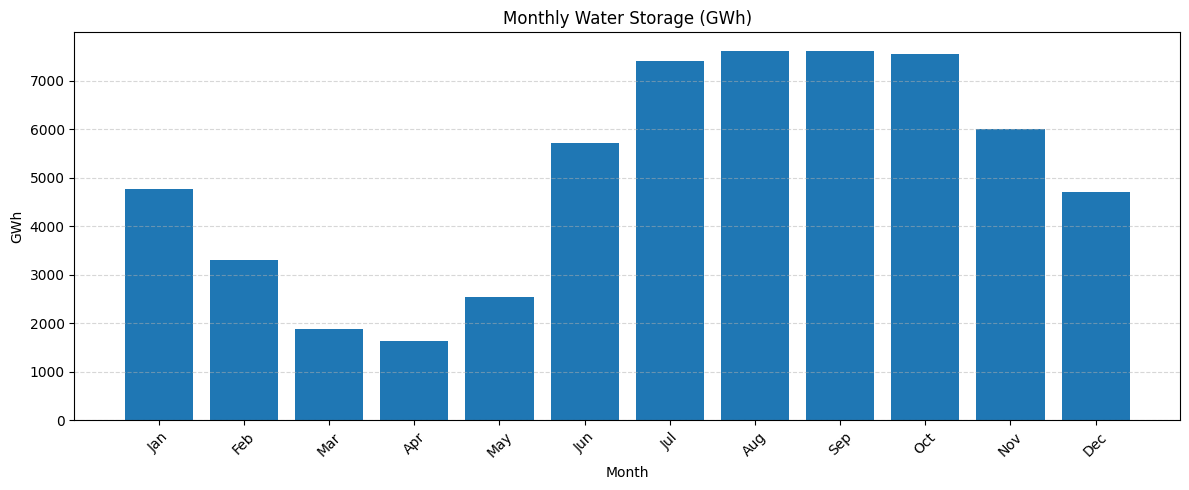

In [21]:
visualize_storage_monthly(
    "data/water_monthly_reservoir_2024.csv",
    start_date="2024-01-01",
    end_date="2024-12-31"
)

## Part 2 - Modify Prof Züttel data into a manageable format  

Import of the Cost table from excel into a fully functioning csv already done. 

In [ ]:
# I need to do the groups: 
### 1 - Production (go from natural ressource to electricity): 
HYD_S = ["Lake", "Hydro Turb", "Electricity", "Grid"]
HYD_R = ["River", "Hydro Turb", "Electricity", "Grid"]
THERM = ["Fuel Tank", "Fuel Transport", "Pipeline", "Ship transport", "Combined cycle power plant", "Electricity", "Grid"]
THERM_EX = ["Fuel Tank", "ICE"]
THERM_D = ["Fuel Tank", "Combined cycle power plant", "Electricity", "Grid"]
PV = ["PV", "Inverter DC/AC", "Battery", "Converter AC/DC", "Electricity", "Grid"]
WD_ON = ["Wind (onshore)", "Inverter DC/AC", "Battery", "Converter AC/DC", "Electricity", "Grid"]
THERM_G = ["Biogas","Combined cycle power plant",  "Electricity", "Grid"]
THERM_M = ["Biomass","Combined cycle power plant",  "Electricity", "Grid"]
H2P_G = ["H2 Storage UG 200bar","Hydrogen Transport","Combined cycle power plant", "Electricity", "Grid"]
H2P_L = ["Liquid storage","Hydrogen Transport","Combined cycle power plant", "Electricity", "Grid"]
SOL_SALT = ["Solar concentrator salt", "Steam generator", "Combined cycle power plant", "Electricity", "Grid"]
SOL_STEAM = ["Solar concentrator steam", "Combined cycle power plant", "Electricity", "Grid"]
BIO_OIL_ICE = ["Biooil", "Refining", "Fuel Tank", "ICE", "Electricity", "Grid"]
PALM_ICE = ["Palm oil", "Pyrolysis", "Biooil", "Cracking", "Refining", "ICE"]
BIO_WOOD = ["Wood", "Pyrolysis", "Biooil", "Steam reforming", "Combined cycle power plant", "Electricity", "Grid"]
WD_OFF = ["Wind (offshore)", "Inverter DC/AC", "Battery", "Converter AC/DC", "Electricity", "Grid"]
IMP_BIOG = ["Biogas (50% CH4)", "Pipeline", "Biogas purification", "Combined cycle power plant", "Electricity", "Grid"]
NH3_P = ["Ammonia cracking", "H2 Storage UG 200bar", "Hydrogen Transport", "Combined cycle power plant", "Electricity", "Grid"]


### 2 - Storage (Go from electricty to storage):
HY_LE = ["Hydro pump", "Lake"]
H2_G = ["Electrolyzer", "Compressor 30-200bar", "H2 Storage UG 200bar"]
H2_GL =["Electrolyzer", "Liquifaction", "Ship transport", "Liquid storage", "Liquid to gas", "Compressor 30-200bar", "H2 Storage UG 200bar"]
H2_L =["Electrolyzer", "Liquifaction", "Liquid storage"]
SYN_FT = ["Electrolyzer", "CO2 Capture 400 ppm", "H2, CO2 compression", "FT-Synthesis", "Refining", "Fuel Tank"]
SYN_METH = ["Electrolyzer", "CO2 Capture 400 ppm", "Sabatier reaction", "Methane compression", "CH4 storage 200bar"]
NH3_FULL = ["Electrolyzer", "N2 separation", "N2,H2 compression", "NH3 synthesis", "Ammonia liquifaction", "Ammonia storage"]
SYN_CRACK = ["Electrolyzer", "Palm oil", "H2, CO2 compression", "Cracking", "Refining", "Fuel Tank"]
CH4_BIO = ["Electrolyzer", "Biogas purification", "Sabatier reaction", "Methane compression", "Biogas (50% CH4)"]

# Save the ppu_data table (PPU and list of components) to a CSV
import pandas as pd

ppu_data = [
    {"PPU": "HYD_S", "Components": HYD_S, "Category": "Production"},
    {"PPU": "HYD_R", "Components": HYD_R, "Category": "Production"},
    {"PPU": "THERM", "Components": THERM, "Category": "Production"},
    {"PPU": "PV", "Components": PV, "Category": "Production"},
    {"PPU": "WD_ON", "Components": WD_ON, "Category": "Production"},
    {"PPU": "WD_OFF", "Components": WD_OFF, "Category": "Production"},
    {"PPU": "THERM_G", "Components": THERM_G, "Category": "Production"},
    {"PPU": "THERM_M", "Components": THERM_M, "Category": "Production"},
    {"PPU": "H2P_G", "Components": H2P_G, "Category": "Production"},
    {"PPU": "H2P_L", "Components": H2P_L, "Category": "Production"},
    {"PPU": "SOL_SALT", "Components": SOL_SALT, "Category": "Production"},
    {"PPU": "SOL_STEAM", "Components": SOL_STEAM, "Category": "Production"},
    {"PPU": "BIO_OIL_ICE", "Components": BIO_OIL_ICE, "Category": "Production"},
    {"PPU": "PALM_ICE", "Components": PALM_ICE, "Category": "Production"},
    {"PPU": "BIO_WOOD", "Components": BIO_WOOD, "Category": "Production"},
    {"PPU": "WD_OFF", "Components": WD_OFF, "Category": "Production"},
    {"PPU": "IMP_BIOG", "Components": IMP_BIOG, "Category": "Production"},
    {"PPU": "NH3_P", "Components": NH3_P, "Category": "Production"},
    {"PPU": "H2_G", "Components": H2_G, "Category": "Storage"},
    {"PPU": "H2_GL", "Components": H2_GL, "Category": "Storage"},
    {"PPU": "H2_L", "Components": H2_L, "Category": "Storage"},
    {"PPU": "SYN_FT", "Components": SYN_FT, "Category": "Storage"},
    {"PPU": "SYN_METH", "Components": SYN_METH, "Category": "Storage"},
    {"PPU": "NH3_FULL", "Components": NH3_FULL, "Category": "Storage"},
    {"PPU": "SYN_CRACK", "Components": SYN_CRACK, "Category": "Storage"},
    {"PPU": "CH4_BIO", "Components": CH4_BIO, "Category": "Storage"},
]

ppu_df = pd.DataFrame(ppu_data)
ppu_df["Components"] = ppu_df["Components"].apply(str)
ppu_df.to_csv("data/ppu_constructs_components.csv", index=False)
display(ppu_df)
print("Saved PPU constructs and their components to data/ppu_constructs_components.csv")

In [ ]:
import pandas as pd

rows = [
    # Demand & growth
    ("demand_base_twh_per_year", "demand", 62, "TWh/year", "", "", "Swiss electricity demand in 2019"),
    ("demand_target_twh_per_year", "demand", 113, "TWh/year", "", "", "Electrified demand incl. nuclear replacement (2050)"),
    ("demand_additional_twh_per_year", "demand", 74, "TWh/year", "", "", "Increment vs. 2019 needed from renewables"),
    ("demand_electrification_addition_twh_per_year", "demand", 53, "TWh/year", "", "", "Added demand from electrification of uses"),
    ("demand_nuclear_replacement_twh_per_year", "demand", 21, "TWh/year", "", "", "Added demand to replace nuclear output"),
    ("buildout_cadence_twh_per_year", "deployment", 2.4, "TWh/year", "", "", "Average annual new production to 2050"),
    # Storage sizing rules (system-level)
    ("day_night_storage_share_of_annual", "storage_rules", 0.0025, "fraction of annual demand", 0.0025, 0.0025, "Rule of thumb: 0.25% of annual electricity demand"),
    ("seasonal_storage_share_of_annual", "storage_rules", 0.25, "fraction of annual demand", 0.25, 0.25, "Rule of thumb: 25% of annual electricity demand"),
    ("seasonal_storage_absolute_twh", "storage_rules", 20, "TWh", "", "", "Seasonal storage energy target for winter shift"),
    ("seasonal_intake_power_required_gw", "storage_rules", 20, "GW", "", "", "Summer absorption power to fill seasonal storage"),
    ("pv_peak_power_expected_gw", "supply_profile", 90, "GW", "", "", "Expected PV noon peak for +50 TWh/y PV"),
    ("battery_power_cap_target_gw", "supply_profile", 32, "GW", "", "", "Target capped grid peak after local batteries"),
    # PPU definition
    ("ppu_output_electricity_twh_per_year", "ppu", 8.76, "TWh/year", "", "", "Energy delivered per PPU (on demand)"),
    # Redundancy & policy levers
    ("ppu_required_count_core", "planning", 6, "count", "", "", "PPUs to supply missing band electricity (53 TWh/y)"),
    ("ppu_required_count_redundancy", "planning", 2, "count", "", "", "Additional PPUs for redundancy (≈33%)"),
    ("dam_height_increase_pct", "planning", 26, "%", "", "", "Dam raise to double lake storage capacity"),
    ("storage_shift_from_summer_to_winter_twh", "planning", 9, "TWh/year", "", "", "Shift enabled by higher dams"),
    ("biomass_for_heating_current_twh_per_year", "planning", 15, "TWh/year", "", "", "Current biomass allocated to heating"),
    ("biomass_for_heating_additional_twh_per_year", "planning", 5, "TWh/year", "", "", "Additional biomass to heating"),
    ("rooftop_pv_potential_twh_per_year", "planning", 24, "TWh/year", "", "", "All feasible roof areas covered with PV"),
    # Economics & finance
    ("grid_cost_adder_chf_per_kwh", "costing", 0.09, "CHF/kWh", "", "", "Adder to production cost for grid"),
    ("finance_interest_rate_per_year", "costing", 0.02, "1/year", "", "", "Interest rate Z in annuity formula"),
    # Future component cost/efficiency assumptions
    ("pv_future_capex_chf_per_kwp", "future_costs", 200, "CHF/kWp", "", "", "Assumed future PV CAPEX"),
    ("battery_future_capex_chf_per_kwh", "future_costs", 55, "CHF/kWh", "", "", "Assumed future battery CAPEX"),
    ("electrolyser_future_capex_chf_per_kw", "future_costs", 500, "CHF/kW", "", "", "Assumed future electrolyser CAPEX"),
    ("electrolyser_future_efficiency", "future_costs", 0.90, "fraction", "", "", "Assumed future electrolyser efficiency"),
    ("power_electronics_future_capex_chf_per_kw", "future_costs", 200, "CHF/kW", "", "", "Converters/inverters assumed future CAPEX"),
    ("dac_future_cost_chf_per_ton_co2", "future_costs", 200, "CHF/tCO2", "", "", "Assumed future DAC cost"),
    ("h2_liquefaction_future_cost_chf_per_kg", "future_costs", 2000, "CHF/kg", "", "", "Assumed future LH2 liquefaction cost"),
    ("h2_future_cost_chf_per_kg_default", "future_costs", 6.0, "CHF/kg", 5.0, 7.0, "Implied future H2 cost (range 5–7)"),
    ("syn_oil_future_cost_chf_per_kg_default", "future_costs", 2.5, "CHF/kg", 2.3, 2.7, "Implied future synthetic oil cost (range)"),
    # PPU technology inputs (areas, storage)
    ("pv_hyd_pv_active_area_km2_per_ppu", "ppu_params", 51, "km^2", "", "", "Active PV area per PV-HYD PPU"),
    ("pv_h2_pv_active_area_km2_per_ppu", "ppu_params", 83, "km^2", "", "", "Active PV area per PV-H2 PPU"),
    ("bio_sf_pv_active_area_km2_per_ppu", "ppu_params", 89, "km^2", "", "", "Active PV area per Bio-SF PPU"),
    ("imp_sf_pv_active_area_km2_per_ppu", "ppu_params", 62, "km^2", "", "", "Active PV area per Imp-SF PPU (abroad)"),
    ("imp_psf_pv_active_area_km2_per_ppu", "ppu_params", 5.6, "km^2", "", "", "Active PV area per Imp-PSF PPU (abroad)"),
    ("imp_h2_pv_active_area_km2_per_ppu", "ppu_params", 113, "km^2", "", "", "Active PV area per Imp-H2 PPU (abroad)"),
    ("bio_sf_biomass_mass_mt_per_year", "ppu_params", 1.5, "Mt/year", "", "", "Dry biomass input per Bio-SF PPU"),
    ("bio_sf_plantation_area_km2", "ppu_params", 7500, "km^2", "", "", "Local plantation area for Bio-SF PPU"),
    ("imp_psf_plantation_area_km2", "ppu_params", 2350, "km^2", "", "", "Plantation area for Imp-PSF PPU"),
    ("imp_sf_dac_co2_mt_per_year", "ppu_params", 2.3, "Mt/year", "", "", "CO2 captured per Imp-SF PPU via DAC"),
    ("imp_h2_h2_cost_today_chf_per_kg", "ppu_params", 19.4, "CHF/kg", "", "", "Reference current cost of imported H2"),
    ("imp_h2_annual_h2_mass_for_1gw_tonnes", "ppu_params", 448000, "t/year", "", "", "H2 consumption for 1 GW CCPP continuous"),
    ("h2_reserve_storage_mass_tonnes", "ppu_params", 112000, "t", "", "", "Reserve LH2 storage mass (≈3 months)"),
    ("h2_liquid_vs_200bar_volume_ratio", "ppu_params", 4, "dimensionless", "", "", "Liquid storage is 4× more compact than 200 bar"),
    ("pv_field_to_active_area_factor", "ppu_params", 2.25, "ratio", 2.0, 2.5, "Field area ≈2–2.5× active PV area"),
    # Storage media densities & civil works
    ("hydrolake_storage_density_kwh_per_m3_mid", "storage_phys", 2.5, "kWh/m^3", 1.0, 4.0, "Electricity storage density for 500–1800 m head"),
    ("excavation_energy_kwh_per_m3", "storage_phys", 30, "kWh/m^3", "", "", "Energy to excavate valley (order of magnitude)"),
    # LCOE per PPU (ex-grid; add grid cost separately)
    ("lcoe_nuc_chf_per_kwh_ex_grid", "lcoe", 0.08, "CHF/kWh", "", "", "Electricity LCOE at PPU (ex-grid)"),
    ("lcoe_pv_hyd_chf_per_kwh_ex_grid", "lcoe", 0.24, "CHF/kWh", "", "", "Electricity LCOE at PPU (ex-grid)"),
    ("lcoe_pv_h2_chf_per_kwh_ex_grid", "lcoe", 0.44, "CHF/kWh", "", "", "Electricity LCOE at PPU (ex-grid)"),
    ("lcoe_bio_sf_to_power_chf_per_kwh_ex_grid", "lcoe", 0.47, "CHF/kWh", "", "", "Electricity LCOE if synthetic fuel used for power"),
    ("lcoe_imp_h2_chf_per_kwh_ex_grid", "lcoe", 1.02, "CHF/kWh", "", "", "Electricity LCOE at PPU (ex-grid)"),
    ("lcoe_imp_sf_to_power_chf_per_kwh_ex_grid", "lcoe", 2.20, "CHF/kWh", "", "", "Electricity LCOE if synfuel (PV+DAC) used for power"),
    ("lcoe_imp_psf_to_power_chf_per_kwh_ex_grid", "lcoe", 0.35, "CHF/kWh", "", "", "Electricity LCOE if palm synfuel used for power"),
    # CAPEX (order-of-magnitude, for constraints/sensitivity)
    ("capex_nuc_bchf", "capex", 10, "BCHF", 8, 12, "Initial CAPEX range"),
    ("capex_pv_hyd_bchf", "capex", 32, "BCHF", "", "", "Initial CAPEX"),
    ("capex_pv_h2_bchf", "capex", 84, "BCHF", "", "", "Initial CAPEX"),
    ("capex_bio_sf_bchf", "capex", 60, "BCHF", "", "", "Initial CAPEX"),
    ("capex_imp_h2_bchf_local", "capex", 7, "BCHF", "", "", "Local CAPEX (excl. abroad infra)"),
    ("capex_imp_h2_bchf_abroad", "capex", 106, "BCHF", "", "", "Abroad CAPEX"),
    ("capex_imp_sf_bchf_local", "capex", 5, "BCHF", "", "", "Local CAPEX"),
    ("capex_imp_sf_bchf_abroad", "capex", 57, "BCHF", "", "", "Abroad CAPEX"),
    ("capex_imp_psf_bchf_local", "capex", 4, "BCHF", "", "", "Local CAPEX"),
    ("capex_imp_psf_bchf_abroad", "capex", 10, "BCHF", "", "", "Abroad CAPEX"),
]

df = pd.DataFrame(rows, columns=["key", "category", "default_value", "unit", "lower_bound", "upper_bound", "notes"])

# Save to CSV
csv_path = "data/optimization_inputs_from_paper.csv"
df.to_csv(csv_path, index=False)

df.head()


## Portfolio Optimization Display: Efficiency Frontier

The efficiency frontier represents the set of optimal portfolios that offer the highest expected return for a given level of risk (volatility), or equivalently, the lowest risk for a given expected return. In the context of Power Production Unit (PPU) optimization, this frontier illustrates the trade-off between maximizing the yearly arithmetic mean return (average of 15-minute discrete returns, $\mathrm{Return}_t = \frac{1}{\mathrm{cost}_t + \varepsilon}$) and minimizing the yearly average price volatility (standard deviation of returns, proxy for cost variability). Portfolios below the frontier are suboptimal, as they provide lower returns for the same risk or higher risk for the same return. The optimal PPU mix lies on this frontier, balancing cost stability with high returns to achieve sovereign, CO2-neutral energy. We simulate multiple portfolio scenarios by varying cost parameters to construct and display this frontier.

In [ ]:
# --- Efficiency Frontier Display ---
# This code simulates multiple PPU portfolios by varying cost parameters,
# computes their yearly mean return and volatility, and plots the efficiency frontier.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Parameters
np.random.seed(42)
n_timesteps = 96 * 365  # 15-min timesteps in a year
epsilon = 1e-6
n_portfolios = 100  # Number of simulated portfolios

# Simulate multiple portfolios by varying cost scale (lower scale = lower costs = higher returns)
scales = np.random.uniform(0.5, 2.0, n_portfolios)  # Cost scales

portfolios = []
for scale in scales:
    costs = np.random.exponential(scale, n_timesteps)
    returns = 1 / (costs + epsilon)
    # Aggregate to daily
    daily_returns = pd.Series(returns).groupby(np.arange(len(returns)) // 96).mean()
    daily_costs = pd.Series(costs).groupby(np.arange(len(costs)) // 96).mean()
    mean_return = daily_returns.mean()
    # Volatility as coefficient of variation of daily costs, in %
    volatility = (daily_costs.std() / daily_costs.mean()) * 100
    portfolios.append((volatility, mean_return))

# Convert to array
portfolios = np.array(portfolios)

# Find the efficiency frontier: portfolios with maximum return for each volatility
sorted_idx = np.argsort(portfolios[:, 0])  # Sort by volatility
efficient = []
for i in sorted_idx:
    if not efficient or portfolios[i, 1] > efficient[-1][1]:
        efficient.append(portfolios[i])

efficient = np.array(efficient)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(portfolios[:, 0], portfolios[:, 1], s=20, alpha=0.5, color='gray', label="All Simulated Portfolios")
ax.plot(efficient[:, 0], efficient[:, 1], 'b-', linewidth=2, label="Efficiency Frontier")
ax.scatter(efficient[:, 0], efficient[:, 1], s=50, color='blue', label="Efficient Portfolios")
ax.set_xlabel('Yearly Average Price Volatility (%)')
ax.set_ylabel('Yearly Arithmetic Mean Return')
ax.set_title('Efficiency Frontier for PPU Portfolios')
ax.legend(loc="best")
ax.grid(True)
plt.show()

# Print the optimal portfolio (highest return on frontier)
optimal_idx = np.argmax(efficient[:, 1])
print(f"Optimal Portfolio - Volatility: {efficient[optimal_idx, 0]:.2f}%, Return: {efficient[optimal_idx, 1]:.4f}")